In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path

In [4]:
root = r"D:\Desktop\智慧能源专项赛-赛题二数据\分布式历史数据\FBS_1_history.csv"
data = pd.read_csv(str(root))
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# 将在 00:00 - 04:45 和 20:00 - 23:45 的数据置为 0, 因为其中有些包含Nan
mask = ((data['TIMESTAMP'].dt.time >= pd.to_datetime('00:00').time()) & (data['TIMESTAMP'].dt.time <= pd.to_datetime('04:45').time())) |  \
       ((data['TIMESTAMP'].dt.time >= pd.to_datetime('20:00').time()) & (data['TIMESTAMP'].dt.time <= pd.to_datetime('23:45').time()))

data.loc[mask, 'POWER'] = 0

data.loc[1824: 1845, 'POWER']

1824    0.0
1825    0.0
1826    0.0
1827    0.0
1828    0.0
1829    0.0
1830    0.0
1831    0.0
1832    0.0
1833    0.0
1834    0.0
1835    0.0
1836    0.0
1837    0.0
1838    0.0
1839    0.0
1840    0.0
1841    0.0
1842    0.0
1843    0.0
1844    NaN
1845    NaN
Name: POWER, dtype: float64

In [5]:
# 去除其中的 Nan
data = data.dropna()
data.shape

(11471, 14)

In [6]:
# 计算相关度
correlation_matrix = data.corr()

correlation_matrix

,POWER,WEATHER1_TMP,WEATHER1_PRES,WEATHER1_RAINFALL,WEATHER1_TCC,WEATHER1_IR,WEATHER1_WS,WEATHER2_TMP,WEATHER2_PRES,WEATHER2_RAINFALL,WEATHER2_TCC,WEATHER2_IR,WEATHER2_WS
POWER,1.000000,0.678929,-0.002622,-0.127824,-0.121771,0.872261,-0.108157,0.715384,0.034561,-0.124654,-0.117543,0.881517,-0.068038
WEATHER1_TMP,0.678929,1.000000,-0.194979,-0.130910,-0.114438,0.727939,0.032065,0.976644,-0.343874,-0.113314,-0.117473,0.726491,0.083988
WEATHER1_PRES,-0.002622,-0.194979,1.000000,-0.140509,-0.106662,0.006370,-0.164942,-0.229074,0.201640,-0.134655,-0.116145,0.009952,-0.179438
WEATHER1_RAINFALL,-0.127824,-0.130910,-0.140509,1.000000,0.266560,-0.138297,0.208559,-0.108575,0.052470,0.939163,0.309918,-0.138760,0.270308
WEATHER1_TCC,-0.121771,-0.114438,-0.106662,0.266560,1.000000,-0.187649,0.185214,-0.087120,0.064994,0.293324,0.818554,-0.172977,0.217180
WEATHER1_IR,0.872261,0.727939,0.006370,-0.138297,-0.187649,1.000000,-0.160629,0.754429,-0.025222,-0.151693,-0.187226,0.985023,-0.123051
WEATHER1_WS,-0.108157,0.032065,-0.164942,0.208559,0.185214,-0.160629,1.000000,0.003673,-0.092500,0.245097,0.238045,-0.174168,0.906955
WEATHER2_TMP,0.715384,0.976644,-0.229074,-0.108575,-0.087120,0.754429,0.003673,1.000000,-0.285786,-0.101735,-0.095193,0.770502,0.052357
WEATHER2_PRES,0.034561,-0.343874,0.201640,0.052470,0.064994,-0.025222,-0.092500,-0.285786,1.000000,0.059230,0.129078,-0.027585,-0.257550
WEATHER2_RAINFALL,-0.124654,-0.113314,-0.134655,0.939163,0.293324,-0.151693,0.245097,-0.101735,0.059230,1.000000,0.350517,-0.154330,0.309963


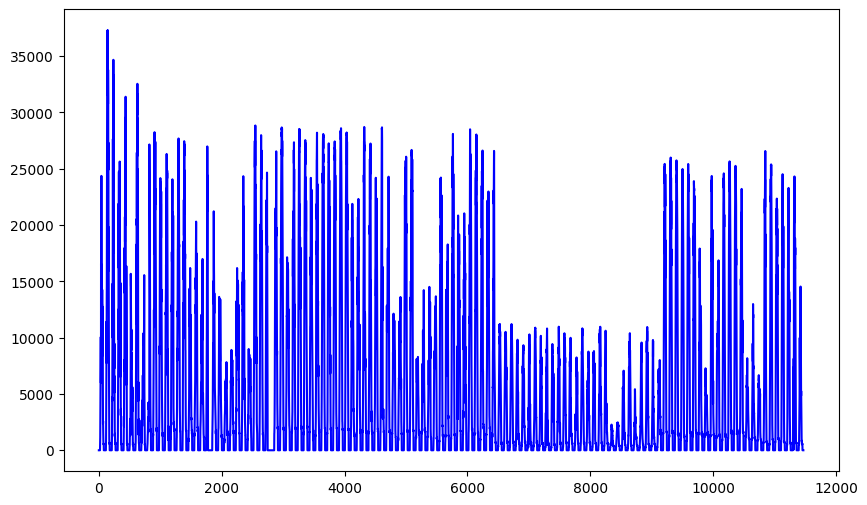

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制原始数据和预测结果的对比图
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(data), 1), data["POWER"], color='blue', label='Original Data')

In [10]:
target_correlation = correlation_matrix['POWER'].abs().sort_values(ascending=False)
target_correlation

POWER                1.000000
WEATHER2_IR          0.881517
WEATHER1_IR          0.872261
WEATHER2_TMP         0.715384
WEATHER1_TMP         0.678929
WEATHER1_RAINFALL    0.127824
WEATHER2_RAINFALL    0.124654
WEATHER1_TCC         0.121771
WEATHER2_TCC         0.117543
WEATHER1_WS          0.108157
WEATHER2_WS          0.068038
WEATHER2_PRES        0.034561
WEATHER1_PRES        0.002622
Name: POWER, dtype: float64

In [44]:
filter_features1 = ["WEATHER1_IR", "WEATHER1_TMP"]
features1 = data[filter_features1]
power1 = data["POWER"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, power1, test_size=0.2, shuffle=False)
X_train1, X_test1 = X_train1.fillna(method='bfill'), X_test1.fillna(method='bfill')
y_train1, y_test1 = y_train1.fillna(value=0), y_test1.fillna(value=0)

X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape, X_train1

((9176, 2),
 (2295, 2),
 (9176,),
 (2295,),
       WEATHER1_IR  WEATHER1_TMP
 0             0.0       20.6720
 1             0.0       20.6678
 2             0.0       20.6635
 3             0.0       20.6593
 4             0.0       20.6550
 ...           ...           ...
 9412          0.0       21.7310
 9413          0.0       21.6573
 9414          0.0       21.5835
 9415          0.0       21.5098
 9416          0.0       21.4360
 
 [9176 rows x 2 columns])

In [45]:
# filter_features = ["WEATHER2_IR", "WEATHER1_IR", "WEATHER2_TMP", "WEATHER1_TMP"]
filter_features = ["WEATHER2_IR", "WEATHER2_TMP"]
features = data[filter_features]
power = data["POWER"]
X_train, X_test, y_train, y_test = train_test_split(features, power, test_size=0.2, shuffle=False)
# X_train, X_test = X_train.dropna(), X_test.dropna()
# y_train, y_test = y_train.dropna(), y_test.dropna()
X_train, X_test = X_train.fillna(method='bfill'), X_test.fillna(method='bfill')
y_train, y_test = y_train.fillna(value=0), y_test.fillna(value=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9176, 2), (2295, 2), (9176,), (2295,))

In [46]:
 # 创建随机森林回归模型对象
rf_model = RandomForestRegressor()

# 使用训练集训练模型
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred.shape
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [47]:
# 计算均方误差（Mean Squared Error）
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 15710245.655222695


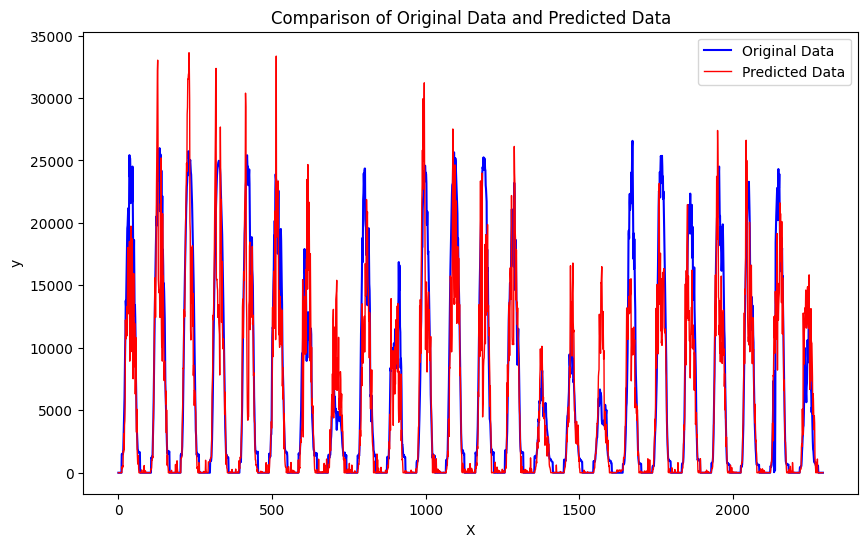

In [48]:
import matplotlib.pyplot as plt

# 绘制原始数据和预测结果的对比图
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(y_pred), 1), y_test, color='blue', label='Original Data')
plt.plot(np.arange(0, len(y_pred), 1), y_pred, color='red', linewidth=1, label='Predicted Data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of Original Data and Predicted Data')
plt.legend()
plt.show()

In [49]:
# 读取10.1 到 10.7的天气预测数据
weather_data = r"D:\Desktop\智慧能源专项赛-赛题二数据\天气预报数据\分布式功率预测天气预报数据-23年10月1日-10月7日\FBS_1_20231001-20231007_weather.csv"
data_predict = pd.read_csv(weather_data)
# data_predict['TIMESTAMP'] = pd.to_datetime(data_predict['TIMESTAMP'])
data_predict = data_predict[filter_features]
predict_pred = rf_model.predict(data_predict)

predict_pred.shape

(673,)

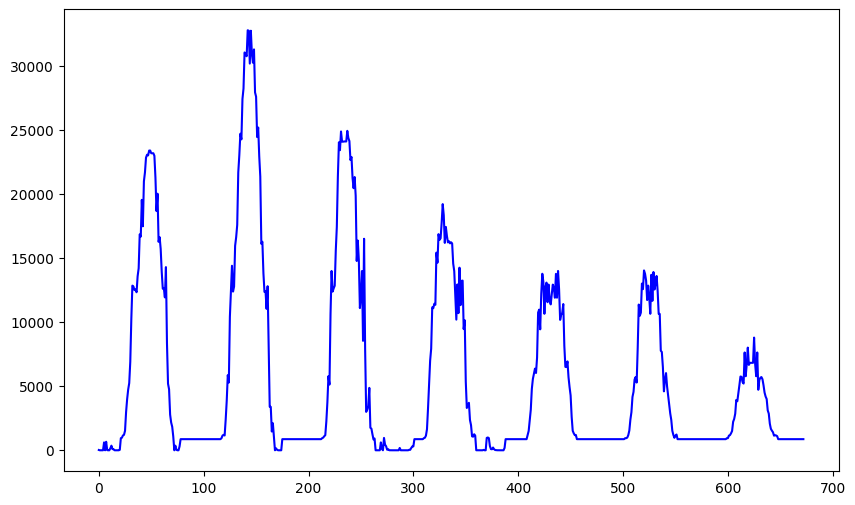

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(predict_pred), 1), predict_pred, color='blue', label='Original Data')

In [51]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [52]:
model_xgb = xgb.XGBRegressor()

In [54]:
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

In [57]:
model_xgb1 = xgb.XGBRegressor()
print(X_train1.shape, y_train1.shape)
model_xgb1.fit(X_train1, y_train1)
y_pred1 = model_xgb1.predict(X_test1)

(9176, 2) (9176,)


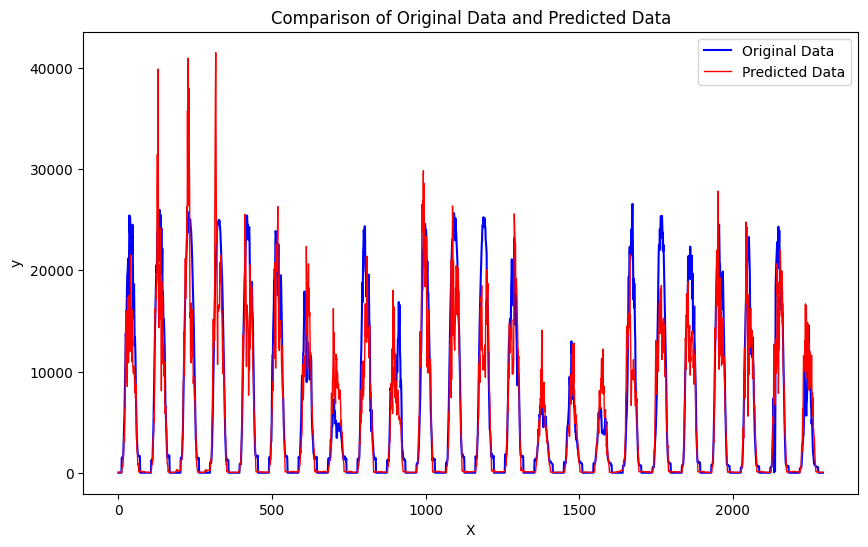

In [58]:
import matplotlib.pyplot as plt

# 绘制原始数据和预测结果的对比图
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(y_pred), 1), y_test, color='blue', label='Original Data')
plt.plot(np.arange(0, len(y_pred), 1), (y_pred+y_pred1)/2, color='red', linewidth=1, label='Predicted Data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of Original Data and Predicted Data')
plt.legend()
plt.show()

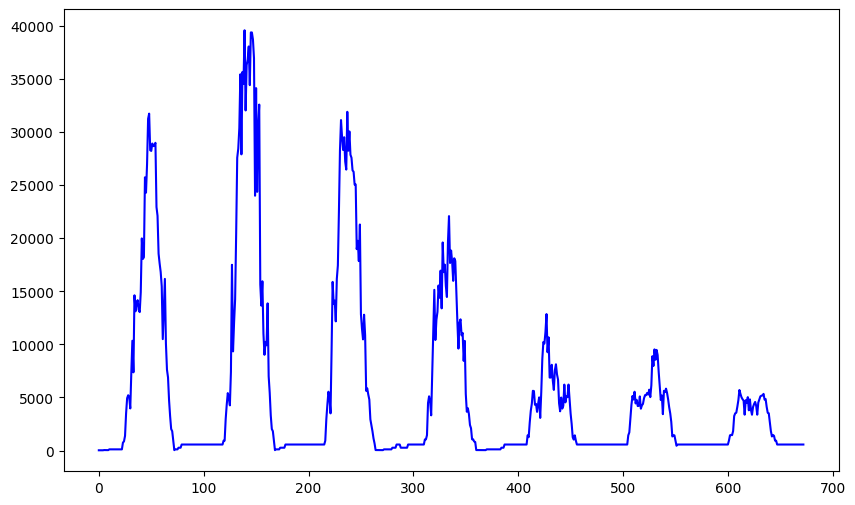

In [59]:
# 读取10.1 到 10.7的天气预测数据
weather_data = r"D:\Desktop\智慧能源专项赛-赛题二数据\天气预报数据\分布式功率预测天气预报数据-23年10月1日-10月7日\FBS_1_20231001-20231007_weather.csv"
data_predict = pd.read_csv(weather_data)
# data_predict['TIMESTAMP'] = pd.to_datetime(data_predict['TIMESTAMP'])
data_predict = data_predict[filter_features]
predict_pred = model_xgb.predict(data_predict)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(predict_pred), 1), predict_pred, color='blue', label='Original Data')